# Capstone Project - Battle of the Neighborhood

## Exploring Food Venues in London

This project wants to segment the boroughs and neighbourhoods in London into different clusters and examine the distribution of the various ethnic restaurant around the city

##### Download Libraries

In [3]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

import urllib.request

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


##### Download London Dataset with neighborhood coordinates and clean the data

In [4]:
london_dataset = pd.read_csv('https://raw.githubusercontent.com/Giorgiuz/IBM-Data-Science-Course/master/London_coordinates_.csv',error_bad_lines=False)
print(london_dataset.shape)
london_dataset.head()

(297, 6)


,Neighborhood,Borough,Post Town,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,51.49245,0.12127
1,Acton,Hammersmith and Fulham,LONDON,W3,51.51324,-0.26746
2,Aldgate,City,LONDON,EC3,51.51200,-0.08058
3,Aldwych,Westminster,LONDON,WC2,51.51651,-0.11968
4,Anerley,Bromley,LONDON,SE20,51.41009,-0.05683


In [5]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(london_dataset['Borough'].unique()),london_dataset.shape[0]))

The dataframe has 46 boroughs and 297 neighborhoods.


In [6]:
london_df = london_dataset.drop(['Post Town', 'Postcode'],axis = 1)

london_df.head()

,Neighborhood,Borough,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",51.49245,0.12127
1,Acton,Hammersmith and Fulham,51.51324,-0.26746
2,Aldgate,City,51.51200,-0.08058
3,Aldwych,Westminster,51.51651,-0.11968
4,Anerley,Bromley,51.41009,-0.05683


##### Render a London map through folium library

In [7]:
address = 'London, UK'

geolocator_ = Nominatim(user_agent="uk_explorer")
location = geolocator_.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [176]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat,lng,borough,neighborhood in zip(london_df['Latitude'],london_df['Longitude'],london_df['Borough'],london_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_london)
    
map_london

##### Call Forsquare API to get data for food venues

In [9]:
CLIENT_ID = 'N15BO5NNPF2UKM2MVAWGPSRMZHAWOENF533ECQHDXU3NFM1K' # your Foursquare ID
CLIENT_SECRET = '3CG4P3B1KHAYWRRS3ATY5L1SWYTXWNPHCD340NFO4WXIXQ5V' # your Foursquare Secret
VERSION = '20200501'
LIMIT = 200
category_id = '4d4b7105d754a06374d81259'

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            category_id,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
london_food = getNearbyVenues(names=london_df['Neighborhood'],
                                   latitudes=london_df['Latitude'],
                                   longitudes=london_df['Longitude']
                                  )


Abbey Wood
Acton
Aldgate
Aldwych
Anerley
Angel
Archway
Arnos Grove
Balham
Bankside
Barbican
Barnes
Barnsbury
Battersea
Bayswater
Bedford Park
Belgravia
Bellingham
Belsize Park
Bermondsey
Bethnal Green
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Bloomsbury
Bounds Green
Bow
Bowes Park
Brent Cross
Brent Park
Brixton
Brockley
Bromley (also Bromley-by-Bow)
Brompton
Brondesbury
Brunswick Park
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Cann Hall
Canning Town
Canonbury
Castelnau
Catford
Chalk Farm
Charing Cross
Charlton
Chelsea
Childs Hill
Chinatown
Chinbrook
Chingford
Chiswick
Church End
Clapham
Clerkenwell
Colindale
Colliers Wood
Colney Hatch
Covent Garden
Cricklewood
Crofton Park
Crossness
Crouch End
Crystal Palace
Cubitt Town
Custom House
Dalston
Dartford
De Beauvoir Town
Denmark Hill
Deptford
Dollis Hill
Dulwich
Ealing
Earls Court
Earlsfield
East Dulwich
East Finchley
East Ham
East Sheen
Edmonton
Elephant and Castle
Eltham
Farringdon
Finchley
Finsbur

In [13]:
print(london_food.shape)
london_food.head()

(19624, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.49245,0.12127,Greggs,51.490164,0.121305,Bakery
1,Abbey Wood,51.49245,0.12127,Taj Mahal Indian Restaurant,51.491146,0.120691,Indian Restaurant
2,Abbey Wood,51.49245,0.12127,New Winson Chinese,51.490102,0.121283,Chinese Restaurant
3,Abbey Wood,51.49245,0.12127,Abbey Cafe,51.489754,0.120822,Café
4,Abbey Wood,51.49245,0.12127,The Crafty Cafe by Sharon,51.487449,0.112696,Café


In [14]:
print('There are {} uniques venue categories.'.format(len(london_food['Venue Category'].unique())))

There are 129 uniques venue categories.


##### Remove from the venue all generic categories

In [15]:
london_food.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Café                               2959
Italian Restaurant                 1215
Pizza Place                        1060
Bakery                              989
Indian Restaurant                   944
Restaurant                          766
Sandwich Place                      569
Fast Food Restaurant                553
French Restaurant                   517
Burger Joint                        498
Chinese Restaurant                  467
Turkish Restaurant                  418
Thai Restaurant                     393
Japanese Restaurant                 385
Breakfast Spot                      381
Gastropub                           364
Middle Eastern Restaurant           334
Deli / Bodega                       321
Vietnamese Restaurant               315
Fish & Chips Shop                   309
Sushi Restaurant                    266
English Restaurant                  261
Steakhouse                          254
Mediterranean Restaurant            249
Tapas Restaurant         

In [16]:
categories = london_food['Venue Category'].unique().tolist()
categories

['Bakery',
 'Indian Restaurant',
 'Chinese Restaurant',
 'Café',
 'Fish & Chips Shop',
 'Creperie',
 'Fast Food Restaurant',
 'Breakfast Spot',
 'Sushi Restaurant',
 'Falafel Restaurant',
 'Eastern European Restaurant',
 'Japanese Restaurant',
 'Korean Restaurant',
 'Sandwich Place',
 'Lebanese Restaurant',
 'Halal Restaurant',
 'Pizza Place',
 'Middle Eastern Restaurant',
 'Portuguese Restaurant',
 'Burger Joint',
 'Cafeteria',
 'Diner',
 'Noodle House',
 'Mediterranean Restaurant',
 'Salad Place',
 'French Restaurant',
 'Asian Restaurant',
 'South American Restaurant',
 'Steakhouse',
 'Colombian Restaurant',
 'Restaurant',
 'BBQ Joint',
 'Argentinian Restaurant',
 'Italian Restaurant',
 'Latin American Restaurant',
 'Vietnamese Restaurant',
 'Seafood Restaurant',
 'Deli / Bodega',
 'Szechuan Restaurant',
 'Food Truck',
 'Empanada Restaurant',
 'Food Stand',
 'Burrito Place',
 'Bistro',
 'Cantonese Restaurant',
 'Poke Place',
 'Mexican Restaurant',
 'English Restaurant',
 'German Rest

In [141]:
general_categories = [
 'Bakery',
 'Café',
 'Salad Place',
 'Restaurant',
 'Fast Food Restaurant',
 'Sandwich Place',
 'Burger Joint',
 'Gastropub',
 'Wings Joint',
 'Deli / Bodega',
 'Breakfast Spot',
 'Donut Shop',
 'Bagel Shop',
 'Food Truck',
 'Soup Place',
 'Food Stand',
 'Fried Chicken Joint',
 'Bistro',
 'Food Court',
 'Diner',
 'Cafeteria',
 'Snack Place',
 'Food',
 'Buffet',
 'Gluten-free Restaurant',
 'Currywurst Joint',
 'Comfort Food Restaurant',
 'Hot Dog Joint',
 'BBQ Joint',
 'Grilled Meat Restaurant']

In [142]:
cultural_cuisine = list(set(categories)-set(general_categories))
cultural_cuisine

['Indian Restaurant',
 'Australian Restaurant',
 'Seafood Restaurant',
 'French Restaurant',
 'Noodle House',
 'Chaat Place',
 'Middle Eastern Restaurant',
 'Pizza Place',
 'Szechuan Restaurant',
 'Poke Place',
 'Ethiopian Restaurant',
 'Veneto Restaurant',
 'Yakitori Restaurant',
 'American Restaurant',
 'Colombian Restaurant',
 'Iraqi Restaurant',
 'Sri Lankan Restaurant',
 'Modern European Restaurant',
 'Brazilian Restaurant',
 'Irish Pub',
 'Polish Restaurant',
 'Scottish Restaurant',
 'Cigkofte Place',
 'Brasserie',
 'Moroccan Restaurant',
 'Kebab Restaurant',
 'Arepa Restaurant',
 'Italian Restaurant',
 'Vegetarian / Vegan Restaurant',
 'German Restaurant',
 'Creperie',
 'Indian Chinese Restaurant',
 'South Indian Restaurant',
 'Xinjiang Restaurant',
 'Mamak Restaurant',
 'Peruvian Restaurant',
 'Okonomiyaki Restaurant',
 'Taco Place',
 'Dumpling Restaurant',
 'Afghan Restaurant',
 'New American Restaurant',
 'Ramen Restaurant',
 'Scandinavian Restaurant',
 'Hungarian Restaurant'

In [143]:
london_food_venues = london_food[london_food['Venue Category'].isin(cultural_cuisine)].reset_index()
print(london_food_venues.shape)
london_food_venues.head()

(11073, 8)


,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,Abbey Wood,51.49245,0.12127,Taj Mahal Indian Restaurant,51.491146,0.120691,Indian Restaurant
1,2,Abbey Wood,51.49245,0.12127,New Winson Chinese,51.490102,0.121283,Chinese Restaurant
2,5,Abbey Wood,51.49245,0.12127,Frank's Fish Bar,51.487151,0.112231,Fish & Chips Shop
3,7,Acton,51.51324,-0.26746,Bake Me,51.508452,-0.268543,Creperie
4,11,Acton,51.51324,-0.26746,Atariya,51.510417,-0.288059,Sushi Restaurant


##### Add boroughs to the dataset

In [144]:
london_food_2 = pd.merge(left=london_food_venues, right=london_df, how='left', left_on='Neighborhood', right_on='Neighborhood')
london_food_2 = london_food_2.drop(['Latitude','Longitude'], axis = 1)
print(london_food_2.shape)
london_food_2.head()

(11073, 9)


,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
0,1,Abbey Wood,51.49245,0.12127,Taj Mahal Indian Restaurant,51.491146,0.120691,Indian Restaurant,"Bexley, Greenwich"
1,2,Abbey Wood,51.49245,0.12127,New Winson Chinese,51.490102,0.121283,Chinese Restaurant,"Bexley, Greenwich"
2,5,Abbey Wood,51.49245,0.12127,Frank's Fish Bar,51.487151,0.112231,Fish & Chips Shop,"Bexley, Greenwich"
3,7,Acton,51.51324,-0.26746,Bake Me,51.508452,-0.268543,Creperie,Hammersmith and Fulham
4,11,Acton,51.51324,-0.26746,Atariya,51.510417,-0.288059,Sushi Restaurant,Hammersmith and Fulham


##### Modify the dataframe for the k-means clustering

In [145]:

london_onehot = pd.get_dummies(london_food_2[['Venue Category']], prefix="", prefix_sep="")


london_onehot['Neighborhood'] = london_food_2['Neighborhood'] 


fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
manhattan_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brasserie,Brazilian Restaurant,Bulgarian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Cigkofte Place,Colombian Restaurant,Creperie,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,Fish & Chips Shop,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mamak Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Okonomiyaki Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Romanian Restaurant,Russian Restaurant,Scandinavian Restaurant,Scottish Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yakitori Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abbey Wood
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abbey Wood
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abbey Wood
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Acton
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Acton


In [146]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped.shape

(297, 102)

In [147]:
num_top_restaurant = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_restaurant))
    print('\n')

----Abbey Wood----
                     venue  freq
0        Indian Restaurant  0.33
1        Fish & Chips Shop  0.33
2       Chinese Restaurant  0.33
3  Scandinavian Restaurant  0.00
4      Romanian Restaurant  0.00


----Acton----
                         venue  freq
0           Chinese Restaurant  0.18
1            Indian Restaurant  0.11
2                  Pizza Place  0.11
3    Middle Eastern Restaurant  0.07
4  Eastern European Restaurant  0.07


----Aldgate----
                venue  freq
0         Pizza Place  0.08
1  Italian Restaurant  0.08
2  Seafood Restaurant  0.08
3          Steakhouse  0.08
4   French Restaurant  0.08


----Aldwych----
                 venue  freq
0           Steakhouse  0.08
1    French Restaurant  0.08
2          Pizza Place  0.08
3  Japanese Restaurant  0.06
4    Korean Restaurant  0.05


----Anerley----
                venue  freq
0         Pizza Place  0.62
1   Fish & Chips Shop  0.12
2  Chinese Restaurant  0.12
3    Tapas Restaurant  0.12
4   Afgha

In [148]:
def return_most_common_restaurant(row, num_top_restaurant):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_restaurant]

In [149]:
num_top_restaurant = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_restaurant):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))


neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_restaurant(london_grouped.iloc[ind, :], num_top_restaurant)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Abbey Wood,Fish & Chips Shop,Chinese Restaurant,Indian Restaurant,Yakitori Restaurant,Himalayan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
1,Acton,Chinese Restaurant,Indian Restaurant,Pizza Place,Eastern European Restaurant,Lebanese Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Creperie,Fish & Chips Shop,Portuguese Restaurant
2,Aldgate,Pizza Place,French Restaurant,Steakhouse,Seafood Restaurant,Italian Restaurant,Falafel Restaurant,Indian Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant
3,Aldwych,Pizza Place,French Restaurant,Steakhouse,Japanese Restaurant,Korean Restaurant,Falafel Restaurant,Sushi Restaurant,Seafood Restaurant,Italian Restaurant,Argentinian Restaurant
4,Anerley,Pizza Place,Chinese Restaurant,Fish & Chips Shop,Tapas Restaurant,Yakitori Restaurant,Halal Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant


##### K-means clustering

In [150]:
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(london_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

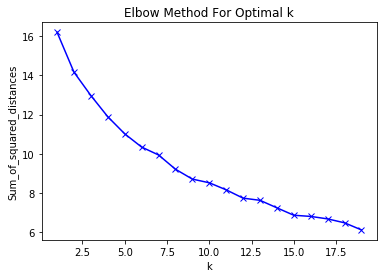

In [155]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [156]:
sil = []
k_range = range(2,21)

for k in k_range:
  kmeans = KMeans(n_clusters = k).fit(london_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(london_grouped_clustering, labels, metric = 'euclidean'))
sil

[0.21680464294055413,
 0.19267104341096408,
 0.17989309877590426,
 0.2275144676890858,
 0.1257119978222758,
 0.1369451585816107,
 0.1579618297654555,
 0.16439240598915145,
 0.19435509885570124,
 0.1808587873839133,
 0.17402565724443128,
 0.1856527284756927,
 0.214353270606945,
 0.21902760186260636,
 0.23258850018649252,
 0.21705381910197893,
 0.22791282793851708,
 0.2473663329887444,
 0.2642816252855186]

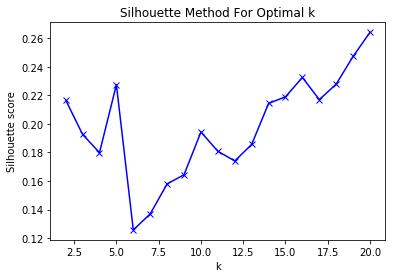

In [157]:
plt.plot(k_range, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [158]:
kclusters = 5


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

kmeans.labels_[0:10] 

array([0, 4, 2, 2, 1, 2, 2, 4, 2, 2], dtype=int32)

In [159]:
#neighborhoods_venues_sorted.drop('Cluster Labels',axis=1,inplace=True)

In [160]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [161]:


london_merged = london_df

london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')



In [162]:
london_merged.dropna(inplace=True)
london_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Abbey Wood,"Bexley, Greenwich",51.49245,0.12127,0,Fish & Chips Shop,Chinese Restaurant,Indian Restaurant,Yakitori Restaurant,Himalayan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
1,Acton,Hammersmith and Fulham,51.51324,-0.26746,4,Chinese Restaurant,Indian Restaurant,Pizza Place,Eastern European Restaurant,Lebanese Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Creperie,Fish & Chips Shop,Portuguese Restaurant
2,Aldgate,City,51.51200,-0.08058,2,Pizza Place,French Restaurant,Steakhouse,Seafood Restaurant,Italian Restaurant,Falafel Restaurant,Indian Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant
3,Aldwych,Westminster,51.51651,-0.11968,2,Pizza Place,French Restaurant,Steakhouse,Japanese Restaurant,Korean Restaurant,Falafel Restaurant,Sushi Restaurant,Seafood Restaurant,Italian Restaurant,Argentinian Restaurant
4,Anerley,Bromley,51.41009,-0.05683,1,Pizza Place,Chinese Restaurant,Fish & Chips Shop,Tapas Restaurant,Yakitori Restaurant,Halal Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant


In [163]:
london_merged.tail()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
292,Wood Green,Haringey,51.60214,-0.11223,4,Indian Restaurant,Chinese Restaurant,Turkish Restaurant,Greek Restaurant,Mediterranean Restaurant,Italian Restaurant,Middle Eastern Restaurant,Eastern European Restaurant,Pizza Place,Falafel Restaurant
293,Woodford,Redbridge,51.50642,-0.12721,2,Indian Restaurant,French Restaurant,Steakhouse,English Restaurant,Pizza Place,Seafood Restaurant,Tapas Restaurant,Japanese Restaurant,Italian Restaurant,Cantonese Restaurant
294,Woodside Park,Barnet,51.61592,-0.17674,3,Italian Restaurant,Turkish Restaurant,Japanese Restaurant,Thai Restaurant,Fish & Chips Shop,Chinese Restaurant,Sushi Restaurant,Brazilian Restaurant,Middle Eastern Restaurant,Portuguese Restaurant
295,Woolwich,Greenwich,51.48207,0.07143,4,Asian Restaurant,Indian Restaurant,Chinese Restaurant,Fish & Chips Shop,Middle Eastern Restaurant,Steakhouse,Thai Restaurant,Portuguese Restaurant,Pizza Place,Italian Restaurant
296,Wormwood Scrubs,Hammersmith and Fulham,51.50645,-0.23691,4,Indian Restaurant,Thai Restaurant,Italian Restaurant,Pizza Place,Japanese Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Falafel Restaurant,Fish & Chips Shop,Vietnamese Restaurant


##### Render a London map with cluster

In [164]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Cluster Analysis

In [165]:
column_i = [5,6,1]
column_ = [list(london_merged.columns.values)[i] for i in column_i]
column_i = [5,6,1]

In [166]:
cluster_0 = london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0,1] + list(range(5, london_merged.shape[1]))]]
cluster_0.head()

,Neighborhood,Borough,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Abbey Wood,"Bexley, Greenwich",Fish & Chips Shop,Chinese Restaurant,Indian Restaurant,Yakitori Restaurant,Himalayan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
65,Crossness,Bexley,Fish & Chips Shop,Chinese Restaurant,Indian Restaurant,Yakitori Restaurant,Himalayan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
82,East Ham,Newham,Indian Restaurant,Fish & Chips Shop,Pizza Place,Turkish Restaurant,Thai Restaurant,Chinese Restaurant,Yakitori Restaurant,Halal Restaurant,English Restaurant,Ethiopian Restaurant
92,Forest Gate,Newham,Indian Restaurant,Asian Restaurant,Fish & Chips Shop,Thai Restaurant,Eastern European Restaurant,Yakitori Restaurant,Himalayan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
115,Hanwell,Ealing,Indian Restaurant,Italian Restaurant,Fish & Chips Shop,Doner Restaurant,English Restaurant,Pizza Place,Turkish Restaurant,Asian Restaurant,Thai Restaurant,Persian Restaurant


In [167]:
for a in column_:
    print(cluster_0[a].value_counts(ascending=False))
    print('------------------------------------------')

Indian Restaurant    7
Fish & Chips Shop    3
Name: 1st Most Common Restaurant, dtype: int64
------------------------------------------
Chinese Restaurant    4
Fish & Chips Shop     2
Turkish Restaurant    2
Italian Restaurant    1
Asian Restaurant      1
Name: 2nd Most Common Restaurant, dtype: int64
------------------------------------------
Newham                 5
Bexley                 2
Ealing                 1
Bexley,  Greenwich     1
Merton                 1
Name: Borough, dtype: int64
------------------------------------------


In [168]:
cluster_1 = london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0,1] + list(range(5, london_merged.shape[1]))]]
cluster_1.head()

,Neighborhood,Borough,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
4,Anerley,Bromley,Pizza Place,Chinese Restaurant,Fish & Chips Shop,Tapas Restaurant,Yakitori Restaurant,Halal Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant
27,Bow,Tower Hamlets,Pizza Place,Italian Restaurant,Portuguese Restaurant,Lebanese Restaurant,Turkish Restaurant,Asian Restaurant,Persian Restaurant,Fish & Chips Shop,Noodle House,German Restaurant
30,Brent Park,Brent,Romanian Restaurant,Indian Restaurant,Modern European Restaurant,Middle Eastern Restaurant,Brazilian Restaurant,Thai Restaurant,Pizza Place,Spanish Restaurant,Falafel Restaurant,Ethiopian Restaurant
33,Bromley (also Bromley-by-Bow),Tower Hamlets,Pizza Place,Italian Restaurant,Portuguese Restaurant,Lebanese Restaurant,Turkish Restaurant,Asian Restaurant,Persian Restaurant,Fish & Chips Shop,Noodle House,German Restaurant
56,Church End,Brent,Romanian Restaurant,Indian Restaurant,Modern European Restaurant,Middle Eastern Restaurant,Brazilian Restaurant,Thai Restaurant,Pizza Place,Spanish Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [169]:
for a in column_:
    print(cluster_1[a].value_counts(ascending=False))
    print('------------------------------------------')

Pizza Place                 24
Romanian Restaurant          8
Mediterranean Restaurant     5
Chinese Restaurant           2
Name: 1st Most Common Restaurant, dtype: int64
------------------------------------------
Indian Restaurant        10
Chinese Restaurant        7
Italian Restaurant        6
Thai Restaurant           5
Portuguese Restaurant     5
Caribbean Restaurant      2
Steakhouse                2
Fish & Chips Shop         2
Name: 2nd Most Common Restaurant, dtype: int64
------------------------------------------
Brent                     7
Southwark                 4
Waltham Forest            4
Greenwich                 4
Tower Hamlets             3
Wandsworth                3
Lambeth                   3
Bromley                   3
Lewisham                  2
Newham                    2
Croydon                   1
Lewisham, Bromley         1
Hackney                   1
Hammersmith and Fulham    1
Name: Borough, dtype: int64
------------------------------------------


In [170]:
cluster_2 = london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0,1] + list(range(5, london_merged.shape[1]))]]
cluster_2.head()

,Neighborhood,Borough,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
2,Aldgate,City,Pizza Place,French Restaurant,Steakhouse,Seafood Restaurant,Italian Restaurant,Falafel Restaurant,Indian Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant
3,Aldwych,Westminster,Pizza Place,French Restaurant,Steakhouse,Japanese Restaurant,Korean Restaurant,Falafel Restaurant,Sushi Restaurant,Seafood Restaurant,Italian Restaurant,Argentinian Restaurant
5,Angel,Islington,Vietnamese Restaurant,Italian Restaurant,French Restaurant,Pizza Place,Falafel Restaurant,Steakhouse,Seafood Restaurant,Sushi Restaurant,English Restaurant,Middle Eastern Restaurant
6,Archway,Islington,Italian Restaurant,Pizza Place,Indian Restaurant,Tapas Restaurant,Japanese Restaurant,Mediterranean Restaurant,Kebab Restaurant,Thai Restaurant,Seafood Restaurant,French Restaurant
8,Balham,Wandsworth,Pizza Place,French Restaurant,Italian Restaurant,Indian Restaurant,Japanese Restaurant,Chinese Restaurant,Portuguese Restaurant,Fish & Chips Shop,Caucasian Restaurant,Moroccan Restaurant


In [171]:
for a in column_:
    print(cluster_2[a].value_counts(ascending=False))
    print('------------------------------------------')

Italian Restaurant       63
Pizza Place              39
Vietnamese Restaurant    14
French Restaurant         5
Japanese Restaurant       3
Greek Restaurant          3
Indian Restaurant         3
Persian Restaurant        2
Sushi Restaurant          1
Caribbean Restaurant      1
Thai Restaurant           1
Turkish Restaurant        1
Name: 1st Most Common Restaurant, dtype: int64
------------------------------------------
Italian Restaurant               38
Pizza Place                      32
French Restaurant                29
Indian Restaurant                10
English Restaurant                9
Japanese Restaurant               8
Thai Restaurant                   3
Vegetarian / Vegan Restaurant     3
Mediterranean Restaurant          2
Korean Restaurant                 1
Persian Restaurant                1
Name: 2nd Most Common Restaurant, dtype: int64
------------------------------------------
Westminster                                     19
Camden                               

In [172]:
cluster_3 = london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0,1] + list(range(5, london_merged.shape[1]))]]
cluster_3.head()

,Neighborhood,Borough,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
17,Bellingham,Lewisham,Italian Restaurant,Pizza Place,Greek Restaurant,Japanese Restaurant,Portuguese Restaurant,Turkish Restaurant,Chinese Restaurant,Yakitori Restaurant,English Restaurant,Ethiopian Restaurant
46,Catford,Lewisham,Italian Restaurant,Pizza Place,Greek Restaurant,Japanese Restaurant,Portuguese Restaurant,Turkish Restaurant,Chinese Restaurant,Yakitori Restaurant,English Restaurant,Ethiopian Restaurant
84,Edmonton,Enfield,Turkish Restaurant,Kebab Restaurant,Noodle House,Seafood Restaurant,Mediterranean Restaurant,Indian Restaurant,Middle Eastern Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
90,Finsbury Park,"Haringey, Islington",Turkish Restaurant,Italian Restaurant,Pizza Place,Thai Restaurant,Chinese Restaurant,Mediterranean Restaurant,Indian Restaurant,Tapas Restaurant,Portuguese Restaurant,Japanese Restaurant
106,Hackney,Hackney,Turkish Restaurant,Pizza Place,Chinese Restaurant,Fish & Chips Shop,Italian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Spanish Restaurant,Dumpling Restaurant


In [173]:
for a in column_:
    print(cluster_3[a].value_counts(ascending=False))
    print('------------------------------------------')

Turkish Restaurant    17
Italian Restaurant     5
Name: 1st Most Common Restaurant, dtype: int64
------------------------------------------
Pizza Place           13
Italian Restaurant     6
Turkish Restaurant     2
Kebab Restaurant       1
Name: 2nd Most Common Restaurant, dtype: int64
------------------------------------------
Haringey               8
Hackney                7
Lewisham               3
Barnet                 2
Enfield                1
Haringey, Islington    1
Name: Borough, dtype: int64
------------------------------------------


In [174]:
cluster_4 = london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0,1] + list(range(5, london_merged.shape[1]))]]
cluster_4.head()

,Neighborhood,Borough,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
1,Acton,Hammersmith and Fulham,Chinese Restaurant,Indian Restaurant,Pizza Place,Eastern European Restaurant,Lebanese Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Creperie,Fish & Chips Shop,Portuguese Restaurant
7,Arnos Grove,Enfield,Fish & Chips Shop,Indian Restaurant,Italian Restaurant,Steakhouse,Kebab Restaurant,Noodle House,Pizza Place,Mediterranean Restaurant,Middle Eastern Restaurant,French Restaurant
22,Blackheath,Lewisham,Indian Restaurant,French Restaurant,Pizza Place,Chinese Restaurant,Fish & Chips Shop,Tapas Restaurant,Creperie,Himalayan Restaurant,Greek Restaurant,Thai Restaurant
23,Blackheath Royal Standard,Greenwich,Indian Restaurant,French Restaurant,Pizza Place,Chinese Restaurant,Fish & Chips Shop,Tapas Restaurant,Creperie,Himalayan Restaurant,Greek Restaurant,Thai Restaurant
24,Blackwall,Tower Hamlets,Italian Restaurant,Indian Restaurant,Chinese Restaurant,Pizza Place,English Restaurant,Sushi Restaurant,Turkish Restaurant,Asian Restaurant,Steakhouse,Spanish Restaurant


In [175]:
for a in column_:
    print(cluster_4[a].value_counts(ascending=False))
    print('------------------------------------------')

Indian Restaurant        28
Italian Restaurant       21
Chinese Restaurant       18
Fish & Chips Shop        14
Portuguese Restaurant     4
Asian Restaurant          3
English Restaurant        2
Name: 1st Most Common Restaurant, dtype: int64
------------------------------------------
Indian Restaurant              36
Pizza Place                    14
Italian Restaurant             10
Chinese Restaurant              7
Korean Restaurant               5
French Restaurant               4
Thai Restaurant                 3
Argentinian Restaurant          2
Asian Restaurant                2
English Restaurant              2
Fish & Chips Shop               2
Eastern European Restaurant     2
Vietnamese Restaurant           1
Name: 2nd Most Common Restaurant, dtype: int64
------------------------------------------
Barnet                    17
Tower Hamlets             15
Lewisham                  10
Greenwich                  9
Hammersmith and Fulham     4
Lambeth                    4
Southwar